In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from celeriteflow import ops

/Users/dfm/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
session = tf.Session()

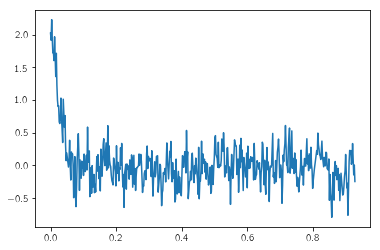

In [4]:
data = np.loadtxt('211351816.dat.ts')

T = tf.float64

t = tf.constant(data[:500, 0]*0.0864, dtype=T)
y = tf.constant(data[:500, 1:2]*1e3, dtype=T)

log_var = np.log(np.var(data[:,1]*1e3))

plt.plot(*(session.run([t, y])))

In [50]:
log_jitter = tf.Variable(log_var, dtype=T)
log_numax = tf.Variable(np.log(220.0), dtype=T)
log_dnu = tf.Variable(np.log(17.0), dtype=T)
gamma = tf.Variable([0.0, 0.0], dtype=T)
log_H = tf.Variable([log_var, log_var], dtype=T)
log_sigma = tf.Variable(np.log(10.0), dtype=T)
log_Q = tf.Variable(8., dtype=T)

numax = tf.exp(log_numax)
nprime = tf.range(-2.0, 3.0, dtype=T)
ell = tf.range(2, dtype=T)
nu = numax + gamma[None, :] + (tf.exp(log_dnu) * (nprime[:, None] + 0.5*ell[None, :]))
log_amp = log_H[None, :] - 0.5*tf.square(nu - numax)*tf.exp(-2*log_sigma)

w0 = 2*np.pi*nu
Q = 1.0 + tf.exp(log_Q)  # Make sure that Q is always greater than 1
Q2 = tf.square(Q)
S0 = tf.exp(log_amp) / Q2

f = tf.sqrt(4.0 * Q2 - 1.0)
nada = tf.constant([], dtype=T)
a = tf.reshape(S0 * w0 * Q, [-1])
b = tf.reshape(S0 * w0 * Q / f, [-1])
c = tf.reshape(0.5 * w0 / Q, [-1])
d = tf.reshape(0.5 * w0 / Q * f, [-1])

# Granulation terms
log_S0_gran = tf.Variable([log_var - 10.0, log_var - 10.0], dtype=T)
log_w0_gran = tf.Variable(np.log([2*np.pi*100.0, 2*np.pi*150.0]), dtype=T)

arg1 = tf.exp(log_S0_gran + log_w0_gran)
arg2 = 0.5 * tf.exp(log_w0_gran)
a = tf.concat([a, arg1], 0)
b = tf.concat([b, arg1], 0)
c = tf.concat([c, arg2], 0)
d = tf.concat([d, arg2], 0)

A, U, V, P = ops.get_celerite_matrices(nada, nada, a, b, c, d, t, tf.exp(log_jitter) + tf.zeros_like(t))
D, W = ops.celerite_factor(A, U, V, P)
z = ops.celerite_solve(U, P, D, W, y)

chi2 = tf.squeeze(tf.matmul(y, z, transpose_a=True)) + tf.reduce_sum(tf.log(D))
log_prob = -0.5*chi2

session.run(tf.global_variables_initializer())
print(session.run(chi2))
session.run(tf.gradients(chi2, [log_S0_gran, log_w0_gran]))

-338.093208779


[array([-44.99239172, -43.58771651]), array([-8.66712406, -6.09096835])]

In [51]:
# # Hacks to test gradients
# eps = 1e-5
# var = y
# targ = tf.reduce_sum(z)
# v = session.run(var)
# g0 = session.run(tf.gradients(targ, var))[0].flatten()

# s = v.shape
# v = v.flatten()
# g = np.empty_like(v)
# for i in range(len(v)):
#     eye = np.zeros_like(v)
#     eye[i] = eps
#     p = session.run(targ, feed_dict={var: (v+eye).reshape(s)})
#     m = session.run(targ, feed_dict={var: (v-eye).reshape(s)})
#     g[i] = 0.5 * (p - m) / eps
    
# inds = [0, 1, 2, 3, -4, -3, -2, -1]
# g[inds], g0[inds], np.max(np.abs(g - g0))

In [52]:
opt = tf.contrib.opt.ScipyOptimizerInterface(chi2, var_list=[log_S0_gran, log_w0_gran])

print(session.run([log_S0_gran, log_w0_gran]))
opt.minimize(session)
print(session.run([log_S0_gran, log_w0_gran]))

[array([-12.62076403, -12.62076403]), array([ 6.44304725,  6.84851236])]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -803.230383
  Number of iterations: 26
  Number of functions evaluations: 74
[array([-5.32764478, -5.02192738]), array([ 2.75502218,  3.59807276])]


In [129]:
import tqdm

class HMCSampler(object):
    
    def __init__(self, log_prob, var_list):
        self.var_list = var_list
        self.log_prob = log_prob
        self.grad_log_prob = tf.gradients(log_prob, var_list)
            
    def sample(self, session, nsteps, nintegrate, epsilon, sigma=1.0, **kwargs):
        feed_dict = kwargs.pop("feed_dict", {})
        initial_vars = session.run(self.var_list, feed_dict=feed_dict, **kwargs)
        sizes = [np.size(v) for v in initial_vars]
        shapes = [np.shape(v) for v in initial_vars]
        
        def get_feed_dict(vector):
            i = 0
            for var, size, shape in zip(self.var_list, sizes, shapes):
                feed_dict[var] = np.reshape(vector[i:i+size], shape)
                i += size
            return feed_dict
        
        def compute_log_prob(vector):
            return session.run(self.log_prob, feed_dict=get_feed_dict(vector), **kwargs)
        
        def compute_grad_log_prob(vector):
            grad = session.run(self.grad_log_prob, feed_dict=get_feed_dict(vector), **kwargs)
            return np.concatenate([np.reshape(v, -1) for v in grad])

        initial_q = np.concatenate([np.reshape(v, -1) for v in initial_vars])
        initial_log_prob = compute_log_prob(initial_q)
        chain = np.empty((nsteps, len(initial_q)))
        for n in tqdm.trange(nsteps):
            q = np.array(initial_q)
            p = np.random.randn(len(initial_q))
            factor = 0.5 * np.dot(p, p / sigma**2)

            # First take a half step in momentum.
            p = p + 0.5 * epsilon * compute_grad_log_prob(q)

            # Alternate full steps in position and momentum.
            for i in range(nintegrate):
                # First, a full step in position.
                q = q + epsilon * p / sigma**2
                # Then a full step in momentum.
                if i < nintegrate - 1:
                    p = p + epsilon * compute_grad_log_prob(q)

            # Finish with a half momentum step to synchronize with the position.
            p = p + 0.5 * epsilon * compute_grad_log_prob(q)

            # Negate the momentum. This step really isn't necessary but it doesn't
            # hurt to keep it here for completeness.
            p = -p

            factor -= 0.5 * np.dot(p, p / sigma**2)

            log_prob = compute_log_prob(q)
            lnpdiff = log_prob - initial_log_prob + factor
            if lnpdiff > 0.0 or np.random.rand() < np.exp(lnpdiff):
                initial_q = q
                initial_log_prob = log_prob
            chain[n] = initial_q
        return chain

In [133]:
sampler = HMCSampler(log_prob, [log_S0_gran, log_w0_gran])
chain = sampler.sample(session, 100, 20, 0.01, sigma=sigma)

100%|██████████| 100/100 [00:22<00:00,  4.67it/s]


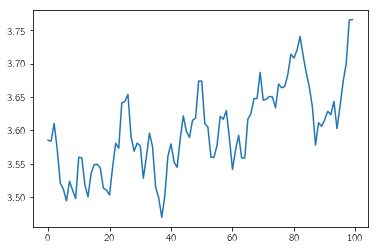

In [135]:
plt.plot(chain[:, 3])

In [114]:
import emcee
var_list = [log_S0_gran, log_w0_gran]
initial_vars = session.run(var_list)
sizes = [np.size(v) for v in initial_vars]
shapes = [np.shape(v) for v in initial_vars]

def get_feed_dict(vector):
    i = 0
    feed_dict = {}
    for var, size, shape in zip(var_list, sizes, shapes):
        feed_dict[var] = np.reshape(vector[i:i+size], shape)
        i += size
    return feed_dict

def emcee_log_prob(vector):
    if np.any(vector < -15) or np.any(vector > 15):
        return -np.inf
    return session.run(log_prob, feed_dict=get_feed_dict(vector))

p0 = np.concatenate([np.reshape(v, -1) for v in initial_vars])
p0 = p0 + 1e-5 * np.random.randn(16, len(p0))
nwalkers, ndim = p0.shape
emcee_sampler = emcee.EnsembleSampler(nwalkers, ndim, emcee_log_prob)
pos, _, _ = emcee_sampler.run_mcmc(p0, 1000);

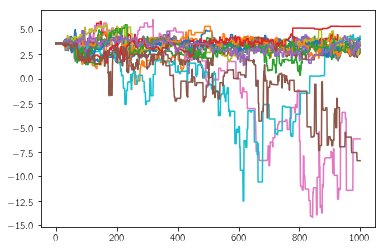

In [128]:
plt.plot(emcee_sampler.chain[:, :, 3].T);

In [121]:
sigma = np.std(emcee_sampler.get_chain(discard=100, flat=True), axis=0)

In [138]:
var_list = [log_S0_gran, log_w0_gran]
initial_vars = session.run(var_list)
sizes = [np.size(v) for v in initial_vars]
shapes = [np.shape(v) for v in initial_vars]
initial = np.concatenate([np.reshape(v, -1) for v in initial_vars])
grad_log_prob = tf.gradients(log_prob, var_list)

def get_feed_dict(vector):
    i = 0
    feed_dict = {}
    for var, size, shape in zip(var_list, sizes, shapes):
        feed_dict[var] = np.reshape(vector[i:i+size], shape)
        i += size
    return feed_dict

def compute_grad_log_prob(vector):
    lp, grad = session.run([log_prob, grad_log_prob], feed_dict=get_feed_dict(vector))
    return lp, np.concatenate([np.reshape(v, -1) for v in grad])

In [139]:
from NUTS import nuts6

In [140]:
results = nuts6(compute_grad_log_prob, 10, 5, initial)

find_reasonable_epsilon= 0.25


KeyboardInterrupt: 